### OCI Data Science - Explore data, Join, and clean

Before using this notebook users have to download neccessary data. We've collected/downloaded the data in advance by utilizing `00 pull data.ipynb` notebook and saved them to `data` folder.

This helps to save time, although data-download may take a few hours.

## Contents:

* <a href='#intro'>Introduction</a>
* <a href='#weatherdata'>Weather Data</a>
* <a href='#lapsdata'>Laps Data</a>
* <a href='#resultdata'>Results Data</a>
* <a href='#Joindata'>Merging Weather and Lap Data</a>
* <a href='#plotsamplelapdata'>Plotting Sample Lap Data</a>

<a id='intro'></a>
## Introduction

Data has already been saved in **data** folder. The data that interests us has `.pickle` extension, and are currently in raw format, which means that it requires pre-processing and preparation before performing feature extraction and model building.

This notebook only focuses on what's in the raw data.

#### Load packages

In [1]:
path = '/home/datascience/redbull-pit-strategy/notebooks'
data_path = '../../redbull-pit-strategy/data/'

In [2]:
# Imports
import os
os.chdir(path)
import pandas as pd
import logging
import json
import pickle
import requests
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

<a id='weatherdata'></a>
## Weather Data
Weather data is available at the session level, and its timestamp is not aligned with laps-data.


In [3]:
file = open('{}{}'.format(data_path, 'weathers_data.pickle'),'rb')
df_weather = pickle.load(file)
# add eventYear to the dataset
df_weather['eventYear'] = pd.DatetimeIndex(df_weather['EventDate']).year # get the year

df_weather.head(2)

,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,RoundNumber,EventName,country,session,EventDate,eventYear
0,0 days 00:00:19.429000,17.4,74.9,939.2,False,23.2,236,0.7,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020
1,0 days 00:01:19.438000,17.4,75.5,939.2,False,22.9,256,0.9,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020


In [4]:
# Print the columns to see the different variables we have
df_weather.columns

Index(['Time', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 'TrackTemp',
       'WindDirection', 'WindSpeed', 'RoundNumber', 'EventName', 'country',
       'session', 'EventDate', 'eventYear'],
      dtype='object')

In [5]:
# average_weather: Get only race sessions, group them by event name, session and date, and get the mean for each one of the groups created for the rest of variables.
# avg. airtemp, humidity, pressure...
ave_weather = df_weather[df_weather['session']=='Race'].groupby(['EventName','session','EventDate']).mean().reset_index().sort_values(['EventName'])
ave_weather.head(5)

,EventName,session,EventDate,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed,RoundNumber,eventYear
0,70th Anniversary Grand Prix,Race,2020-08-09,25.287069,58.556034,1000.950862,0.000000,43.227586,71.931034,2.236207,5.0,2020.0
1,Abu Dhabi Grand Prix,Race,2018-11-25,31.273723,45.437956,1013.111679,0.043796,33.318248,241.175182,2.163504,21.0,2018.0
2,Abu Dhabi Grand Prix,Race,2019-12-01,26.018045,64.471429,1015.383459,0.000000,29.566165,221.097744,1.264662,21.0,2019.0
3,Abu Dhabi Grand Prix,Race,2020-12-13,23.121481,55.446667,1015.847407,0.000000,27.980000,258.244444,2.504444,17.0,2020.0
4,Abu Dhabi Grand Prix,Race,2021-12-12,24.519108,59.054777,1017.710828,0.000000,28.465605,289.191083,0.414650,22.0,2021.0


In [6]:
# exercise: display average weather conditions for the coldest raining races in 2021
exercise_weather = df_weather[
    (df_weather['session']=='Race') &
    (df_weather['Rainfall']==True) &
    (df_weather['eventYear']==2021)
].groupby(['EventName', 'eventYear', 'RoundNumber']).mean().sort_values('AirTemp', ascending=True)
exercise_weather.head(5)

,,,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
EventName,eventYear,RoundNumber,,,,,,,
Emilia Romagna Grand Prix,2021,2,9.707576,72.334848,1011.484848,True,16.869697,184.575758,0.390909
Belgian Grand Prix,2021,12,12.997131,96.451639,970.260656,True,15.270082,295.762295,0.502049
Russian Grand Prix,2021,15,18.112500,67.756250,1023.037500,True,20.112500,140.375000,0.550000
Austrian Grand Prix,2021,9,19.133333,58.100000,935.700000,True,27.783333,188.166667,0.116667
Qatar Grand Prix,2021,20,26.766667,73.666667,1012.000000,True,31.800000,82.333333,0.400000


### Example: Track temp, ambient temp and humidity

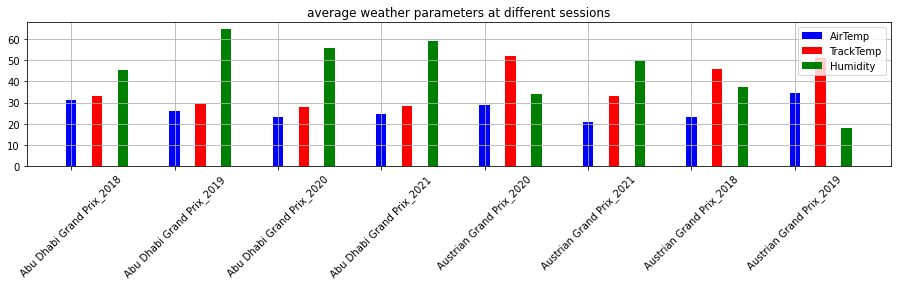

In [7]:
# Visualize track temperature, air temperature and humidity %.
# Valuable because tire life/performance depends on the track temperature
def plot_weather(d_f):

    fig = plt.figure(figsize=(12,2))
    ax = fig.add_axes([0,0,1,1])
    labels = [d_f.loc[x,['EventName']].values[0] +'_'+ 
              str(pd.DatetimeIndex(d_f.loc[x,['EventDate']]).year.values[0]) 
              for x in range(len(d_f))]
    x = np.arange(len(labels) )
    ax.bar(x + 0.00, d_f['AirTemp'], color='b', width=0.10)
    ax.bar(x + 0.25, d_f['TrackTemp'], color='r', width=0.10)
    ax.bar(x + 0.50, d_f['Humidity'], color='g', width=0.10)
    ax.set_xticks(x, labels, rotation=45, fontsize =10)
    ax.legend(['AirTemp','TrackTemp','Humidity'])
    ax.grid()
    plt.title('average weather parameters at different sessions')
    plt.show()
    return


plot_weather(ave_weather[(ave_weather['EventName']=='Austrian Grand Prix') | 
    (ave_weather['EventName']=='Abu Dhabi Grand Prix')].reset_index())

<a id='resultdata'></a>
## Results Data

Load data and select only `Red Bull Racing` data.

Drop non-race and non-qualifying rows from results data and keeping the following columns:
`['Position','FullName','Q1Sec','Q2Sec','Q3Sec', 'RoundNumber','EventName','eventYear','session','TimeSec']`

In [8]:
# Open results_data.pickle, load into dataframe
file = open('{}{}'.format(data_path, 'results_data.pickle'),'rb')
df_res = pickle.load(file)

df_res['eventYear'] = pd.DatetimeIndex(df_res['EventDate']).year
df_res['Q1Sec'] = df_res['Q1']/np.timedelta64(1, 's')
df_res['Q2Sec'] = df_res['Q2']/np.timedelta64(1, 's')
df_res['Q3Sec'] = df_res['Q3']/np.timedelta64(1, 's')
df_res['TimeSec'] = df_res['Time']/np.timedelta64(1, 's')

## Select only Red Bull Racing, only train with RBR data
df_res = df_res[df_res['TeamName']=='Red Bull Racing'] 

## keep only race and qualifier data
df_res = df_res[(df_res['session']=='Race') | (df_res['session']=='Qualifying')]
print('df_res size is: ', df_res.shape)
print('-'*100,'\n')

# from these 27 columns, keep the following columns only.
df_res= df_res[['Position','GridPosition','FullName','Q1Sec','Q2Sec','Q3Sec','RoundNumber','Abbreviation',
                'EventName','eventYear','session','Time','TimeSec','TeamName', 'EventDate']]

# Display round number 5, sort by position and year
df_res[df_res['RoundNumber']==5].sort_values(['Position','eventYear','Abbreviation'], ascending=False)

df_res size is:  (362, 27)
---------------------------------------------------------------------------------------------------- 



,Position,GridPosition,FullName,Q1Sec,Q2Sec,Q3Sec,RoundNumber,Abbreviation,EventName,eventYear,session,Time,TimeSec,TeamName,EventDate
8,9.0,0.0,Sergio Perez,71.644,71.019,71.573,5,PER,Monaco Grand Prix,2021,Qualifying,NaT,NaN,Red Bull Racing,2021-05-22 00:00:00
8,9.0,0.0,Alexander Albon,87.153,86.642,86.669,5,ALB,70th Anniversary Grand Prix,2020,Qualifying,NaT,NaN,Red Bull Racing,2020-08-08 00:00:00
5,6.0,0.0,Pierre Gasly,77.862,76.932,76.708,5,GAS,Spanish Grand Prix,2019,Qualifying,NaT,NaN,Red Bull Racing,2019-05-11 00:00:00
5,6.0,6.0,Pierre Gasly,NaN,NaN,NaN,5,GAS,Spanish Grand Prix,2019,Race,0 days 01:36:10.019000,5770.019,Red Bull Racing,2019-05-12 00:00:00
5,6.0,0.0,Daniel Ricciardo,77.623,77.638,76.818,5,RIC,Spanish Grand Prix,2018,Qualifying,NaT,NaN,Red Bull Racing,2018-05-12 00:00:00
4,5.0,9.0,Alexander Albon,NaN,NaN,NaN,5,ALB,70th Anniversary Grand Prix,2020,Race,0 days 01:20:21.139000,4821.139,Red Bull Racing,2020-08-09 00:00:00
4,5.0,0.0,Max Verstappen,77.411,77.266,76.816,5,VER,Spanish Grand Prix,2018,Qualifying,NaT,NaN,Red Bull Racing,2018-05-12 00:00:00
4,5.0,6.0,Daniel Ricciardo,NaN,NaN,NaN,5,RIC,Spanish Grand Prix,2018,Race,0 days 01:36:20.030000,5780.030,Red Bull Racing,2018-05-13 00:00:00
3,4.0,0.0,Sergio Perez,90.055,89.673,89.036,5,PER,Miami Grand Prix,2022,Qualifying,NaT,NaN,Red Bull Racing,2022-05-07 16:00:00
3,4.0,4.0,Sergio Perez,NaN,NaN,NaN,5,PER,Miami Grand Prix,2022,Race,0 days 01:34:34.896000,5674.896,Red Bull Racing,2022-05-08 15:30:00


<a id='lapsdata'></a>
## Laps Data

Load data and select only `Red Bull Racing`. 

In [9]:
file = open('{}{}'.format(data_path, 'laps_data.pickle'),'rb')

# Columns to drop
drop_cols = ['Sector1Time','Sector2Time','Sector3Time',
             'Sector1SessionTime','Sector2SessionTime','Sector3SessionTime',
            'SpeedI1','SpeedI2','SpeedFL', 'IsAccurate']

# create dataframe, drop columns, drop row numbers as well
df_laps = pickle.load(file).drop(drop_cols, axis=1).reset_index(drop=True)

df_laps['eventYear'] = pd.DatetimeIndex(df_laps['EventDate']).year
df_laps['lapTimeSec'] = df_laps['LapTime']/np.timedelta64(1, 's')

# select only RedBull laps
df_laps = df_laps[df_laps['Team']=='Red Bull Racing']
df_laps.head()

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,SpeedST,IsPersonalBest,Compound,...,Driver,TrackStatus,LapStartDate,RoundNumber,EventName,country,session,EventDate,eventYear,lapTimeSec
135,0 days 00:12:20.615000,33,NaT,1.0,2.0,0 days 00:10:51.251000,0 days 00:12:17.190000,300.0,False,HARD,...,VER,1,2020-07-03 09:01:03.742,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020,NaN
136,0 days 00:39:13.768000,33,NaT,2.0,2.0,0 days 00:37:48.614000,NaT,264.0,False,INTERMEDIATE,...,VER,1,2020-07-03 09:02:33.106,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020,NaN
137,0 days 00:40:35.002000,33,0 days 00:01:21.234000,3.0,3.0,NaT,0 days 00:40:31.541000,295.0,False,INTERMEDIATE,...,VER,1,2020-07-03 09:29:26.259,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020,81.234
138,0 days 00:46:58.006000,33,NaT,4.0,3.0,0 days 00:45:44.543000,NaT,296.0,False,HARD,...,VER,1,2020-07-03 09:30:47.493,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020,NaN
139,0 days 00:48:06.773000,33,0 days 00:01:08.767000,5.0,3.0,NaT,NaT,296.0,False,HARD,...,VER,1,2020-07-03 09:37:10.497,1,Austrian Grand Prix,Austria,FP1,2020-07-03,2020,68.767


#### Check Best Qualifying Times

Check if best Qual time from `results-data` is the same as best Qual time from `lap-data`
Best lap-time from lap Data. are we expecting to see the same best time from `results-data`?

This also allows to **verify** that the data we're working with is accurate and has no inconsistencies between files.

In [10]:
# get the minimum lap time for each event, year, session, driver -> minTime
best_Q = df_laps.groupby(['EventName','eventYear','session','Driver'])['lapTimeSec'].min().reset_index(name='minTime')

In [11]:
# example visualization: filter only from (race or qualifying), Abu Dhabi GP and check Sergio's minTimes.
best_Q[((best_Q['session']=='Race')|(best_Q['session']=='Qualifying') ) & 
(best_Q['EventName']=='Abu Dhabi Grand Prix') &
(best_Q['Driver']=='PER')].sort_values(['session'])
# note only 1 event appearing: it's because 2021 was the first year where this GP happened.

,EventName,eventYear,session,Driver,minTime
46,Abu Dhabi Grand Prix,2021,Qualifying,PER,82.947
48,Abu Dhabi Grand Prix,2021,Race,PER,86.419


In [12]:
# example visualization: filter only from (race or qualifying), Abu Dhabi GP, check Sergio's times for each session.
df_res[['TeamName', 'session','EventDate','eventYear','Q1Sec','Q2Sec','Q3Sec','TimeSec']][((df_res['session']=='Race')|(df_res['session']=='Qualifying') ) & 
(df_res['EventName']=='Abu Dhabi Grand Prix') &
(df_res['Abbreviation']=='PER')].sort_values(['session'])

# why do we have a NaN value?: Sergio had a DNF in the race.

,TeamName,session,EventDate,eventYear,Q1Sec,Q2Sec,Q3Sec,TimeSec
3,Red Bull Racing,Qualifying,2021-12-11,2021,83.35,83.135,82.947,NaN
14,Red Bull Racing,Race,2021-12-12,2021,NaN,NaN,NaN,NaN


Best Qual time from results-data and lap-data are the same! -> Our data is consistent and valid.
We will be using best Qual time as a feature from lap-data. 

(82.947s for Q3, vs. 82.947 minTime above.)

### End of data exploration